# Main Quest04. 폐렴아 기다려라!

**폐렴(Pneumonia)을 진단하는 딥러닝 모델 만들기**

* Set-up
* 데이터 가져오기
* 데이터 시각화
* CNN 모델링
* 데이터 imbalance 처리
* 모델 훈련
* 결과 확인

### **데이터셋**
* 캐글의 Chest X-Ray Images 데이터
* 데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함
*  5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있다.(전체 데이터의 크기는 총 1.2GB 가량)
* 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상

### **폐렴이란?**

폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.

-> 쉽게 말하면 폐에 염증이 생기는 것

### **염증이란?**

염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.

-> 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 장소
-> 폐렴은 폐에서 바이러스나 세균으로부터 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 상황

### **폐렴 구별법**
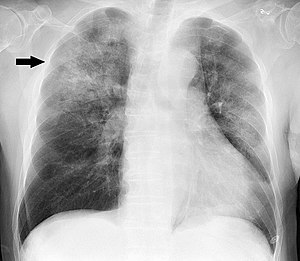
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰된다.
구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵다.

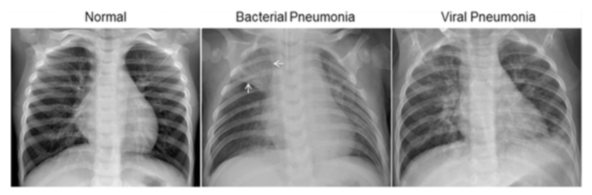
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다.
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.

### **1. Set-up**

패키지(라이브러리)들을 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


필요한 변수들을 생성

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기
데이터를 열어보면 데이터는 train, val(validation), test 로 나누어져 있다.
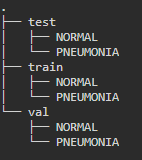

In [4]:
# 데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* train 데이터 - 5216개
* test 데이터 - 624개
* val 데이터 - 16개

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠다.

**rain과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할**

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었다. test_size를 수정하면 개수는 달라질 수 있다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 확인해보자

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있다.

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


* 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다. 
* 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다. 
* 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정
* test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없다.

tf.data 인스턴스를 만들어 보자. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
* 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여본다.
* decode_img 함수와 process_path 함수를 만든다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다. get_label을 이용해서 라벨 값을 가져온다.

In [11]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있다.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있는 것을 볼 수있다. 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미이다.

In [14]:
# test 데이터셋을 만들고, 데이터 개수도 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠다.
* shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.

    예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.


* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.

    예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.


* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화
* 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출한다. 
* 추출된 배치를 image와 label 데이터 셋으로 나눈다. 
* show_batch() 함수를 이용해서 결과 사진을 보자.

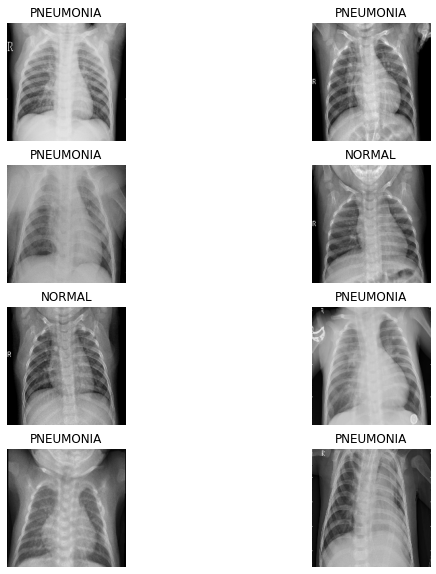

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. CNN 모델링
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠다.

먼저, Convolution block을 만든다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다. 그리고 Max Pooling을 한다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
# Dense Block 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델이다. 전형적인 CNN 모델과는 약간 다른 모델이다.

방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다. 대표적으로 아래와 같은 논문의 사례를 들 수 있다.

* Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있다.

* Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분이다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리
Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있다. 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고하자.

https://3months.tistory.com/414

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅힌다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
* 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다. 
* 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.
* 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용한다.
* optimizer로 'adam'을 사용한다.
* 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
523/523 [==============================] - 118s 107ms/step - loss: 0.5174 - accuracy: 0.7421 - precision: 0.9148 - recall: 0.7207 - val_loss: 1.1791 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
523/523 [==============================] - 54s 104ms/step - loss: 0.3296 - accuracy: 0.8614 - precision: 0.9590 - recall: 0.8500 - val_loss: 0.1346 - val_accuracy: 0.9635 - val_precision: 0.9606 - val_recall: 0.9908
Epoch 3/10
523/523 [==============================] - 55s 105ms/step - loss: 0.2846 - accuracy: 0.8841 - precision: 0.9666 - recall: 0.8745 - val_loss: 0.1314 - val_accuracy: 0.9548 - val_precision: 0.9878 - val_recall: 0.9503
Epoch 4/10
523/523 [==============================] - 55s 104ms/step - loss: 0.2669 - accuracy: 0.8944 - precision: 0.9698 - recall: 0.8856 - val_loss: 0.1301 - val_accuracy: 0.9538 - val_precision: 0.9891 - val_recall: 0.9476
Epoch 5/10
523/523 [==============================] - 55s 106ms/step - loss: 0.2296 - accur

### 결과 확인
이제 결과를 확인해보다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다.

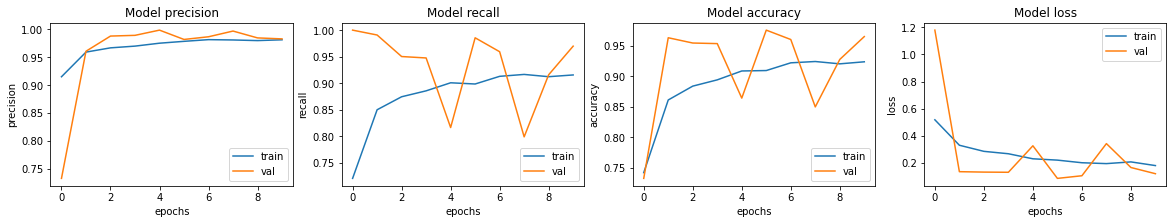

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 59ms/step - loss: 0.6537 - accuracy: 0.8317 - precision: 0.7963 - recall: 0.9821
Loss: 0.6537263989448547,
Accuracy: 0.8317307829856873,
Precision: 0.7962577939033508,
Recall: 0.9820512533187866
